In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [33]:
print("第一步 暸解資料外觀與內容")
print("\n")
#讀取資料 (是DataFrame)
train_url = "https://storage.googleapis.com/py_ml_datasets/train.csv"
train = pd.read_csv(train_url)
#用.head()了解資料的大概情況，不要用print()會比較完整而且好看
print(train.head())
#train.shape : 資料維度
print(train.shape)
print("\n")
#train.dtypes : 每一筆資料的儲存狀態(是integer, float, object等等)
print(train.dtypes)
print("\n")

print("# train.isnull() : 判斷是不是遺漏值，搭配.sum()一口氣了解有多少遺漏值")
print(train.isnull().sum())

第一步 暸解資料外觀與內容


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   N

In [34]:
print("第二步  資料預處理 (Feature Engineering)")
print("\n")
# 1. X 不要納入編號（PassengerId, Ticket）、姓名（Name）與遺漏值過多的變數（Cabin）

# 2. 填補遺漏值 : Embarked, Age
# Embarked 的遺漏值都以 "S" 填補
print(train.Embarked.value_counts())
most_embarked = train.Embarked.value_counts().index[0]
train.Embarked = train.Embarked.fillna(most_embarked)
print("經過剛剛填補遺漏值之後，Embarked遺漏值還有 %s 個" % (sum(train.Embarked.isnull())))
print("\n")
# Age 的遺漏值以中位數填補
age_median = train.Age.median()
train.Age = train.Age.fillna(age_median)
print("經過剛剛填補遺漏值之後，Age遺漏值還有 %s 個" % sum(train.Age.isnull()))

# 3. 類別標籤編碼轉換（使用 One-hot encoding） : Sex, Embarked
# 使用 one-hot encoding 進行類別標籤編碼轉換
train_sex_embarked_dummies = pd.get_dummies(train.loc[:, ["Sex", "Embarked"]])
# 透過.values先換成ndarray。為什麼要轉換過來呢?因為等等要資料水平合併、透過ndarray跑計算阿
train_sex_embarked_ohe = train_sex_embarked_dummies.values.astype(float)

print("\n3. train_sex_embarked_dummies前5列 : \n%s" % train_sex_embarked_dummies.head())
#            Sex_female    Sex_male    Embarked_C    Embarked_Q    Embarked_S
#    0          0             1            0             0             1
#    1          1             0            1             0             0
#    2          1             0            0             0             1
#    3          1             0            0             0             1
#    4          0             1            0             0             1



# 4.   變數新增
# 4-1. 將 SibSp 與 Parch 相加再加 1（自己）成為 family_size
train_copied = train.copy()
train_copied["family_size"] = train_copied["SibSp"] + train_copied["Parch"] + 1
# 4-Final. 合併新增且整理過變數的DataFrame
train_copied =  pd.concat([train_copied, train_sex_embarked_dummies], axis = 1)
print("\n4-Final. train_copied : \n%s" % train_copied.head(3))

# 5. 整理 features, target，用.values把Dataframe轉成ndarray，因為等等要跑計算
train_features_X = (train_copied.loc[:, ["Pclass", "Age", "family_size", "Fare", "Sex_female", "Sex_male", "Embarked_C",  "Embarked_Q", "Embarked_S"]].values)
train_target_Y = train.Survived.values
print("\ntrain_features_X : \n%s" % train_features_X[ 0 , :])

第二步  資料預處理 (Feature Engineering)


S    644
C    168
Q     77
Name: Embarked, dtype: int64
經過剛剛填補遺漏值之後，Embarked遺漏值還有 0 個


經過剛剛填補遺漏值之後，Age遺漏值還有 0 個

3. train_sex_embarked_dummies前5列 : 
   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S
0           0         1           0           0           1
1           1         0           1           0           0
2           1         0           0           0           1
3           1         0           0           0           1
4           0         1           0           0           1

4-Final. train_copied : 
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina 

第三步  分類器


Optimal number of features : 4
RFECV判斷過後，選 4 個 變數 讓模型表現最好


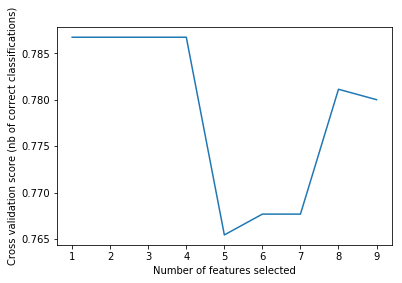

feature_importances_ : 
[ 0.11590419  0.18118106  0.08265722  0.20795824  0.22964418  0.14933806
  0.01204662  0.00759873  0.0136717 ]
 
Features sorted by their score:
(0.22964418219999999, 'Sex_female')
(0.2079582438, 'Fare')
(0.18118106179999999, 'Age')
(0.14933805950000001, 'Sex_male')
(0.1159041941, 'Pclass')
(0.0826572151, 'family_size')
(0.013671697, 'Embarked_S')
(0.0120466189, 'Embarked_C')
(0.0075987277000000002, 'Embarked_Q')


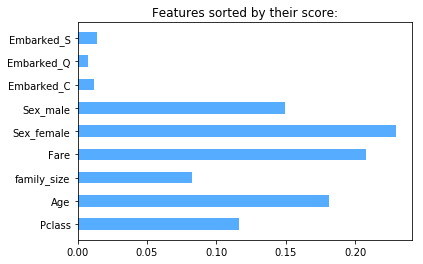



accuracy = 0.912458 


In [41]:
print("第三步  分類器")
print("\n")

from sklearn.ensemble import RandomForestClassifier  #這次分類器不是分類樹，而是隨機森林

# 建立模型
forest_clf = RandomForestClassifier(max_depth = 9, min_samples_split = 5, n_estimators = 100, random_state = 87)
forest_clf.fit(train_features_X, train_target_Y)  # train_features, target : 都是ndarray
             
      # 設定 分類器:隨機森林 的參數 ：  max_depth                  (max_depth第一次採用預設，預設值是大到把你資料分類分乾淨為止)
                                     #min_samples_split          (至少幾個觀測值以上，才能做門檻切分) 
                                     #調 max_depth,  min_samples_split -->都是為了不要過度配適 over fitting  
# 評估模型

# 0. 到底要選幾個變數才好
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(train_features_X, train_target_Y)
print("Optimal number of features : %d" % rfecv.n_features_)
print("RFECV判斷過後，選 %s 個 變數 讓模型表現最好" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()



# 1. feature_importances_
print("feature_importances_ : \n%s\n " % (forest_clf.feature_importances_))

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#Load the dataset
names = train_copied.loc[:, ["Pclass", "Age", "family_size", "Fare", "Sex_female", "Sex_male", "Embarked_C",  "Embarked_Q", "Embarked_S"]]
rfecv.fit(train_features_X, train_target_Y)
print("Features sorted by their score:")

a = sorted(zip(map(lambda x: round(x, 10), forest_clf.feature_importances_), names), reverse=True)
ind = np.arange(0, len(list(a)), 1)
for i in ind :
    print(a[i])

# bar plot the  feature_importances_
import numpy as np
import matplotlib.pyplot as plt


width = 0.5
plt.barh(ind, forest_clf.feature_importances_, width, facecolor = "dodgerblue", align='center', alpha = 0.75)
plt.title("Features sorted by their score:")
plt.yticks(ind, ["Pclass", "Age", "family_size", "Fare", "Sex_female", "Sex_male", "Embarked_C",  "Embarked_Q", "Embarked_S"])
ax = plt.gca()
plt.show()    

print("\n")

# 2. accuracy
print("accuracy = %f " % (forest_clf.score(train_features_X, train_target_Y)))




In [16]:
print("第四步  預測、模型評估")
print("\n")

#對於test data也要做和train data一樣的事情 : 
#先讀取test data, 了解外觀

# 載入預測資料
test_url = "https://storage.googleapis.com/py_ml_datasets/test.csv"
test = pd.read_csv(test_url)
print(test.head())
#了解test data的大概樣貌
print(test.shape)
print("\n")
print(test.dtypes)
print("\n")
#看test data有沒有遺漏值
print("看test data有沒有遺漏值 : \n%s " % (test.isnull().sum()))
print("\n")
#有的話就來填補遺漏值
# Age 的遺漏值以中位數填補
age_median = test.Age.median()
test.Age = test.Age.fillna(age_median)
print("填補過後，Age的遺漏值還有%s個" % (sum(test.Age.isnull())))
# Fare 的遺漏值以中位數填補
fare_median = test.Fare.median()
test.Fare = test.Fare.fillna(fare_median)
print("填補過後，Fare的遺漏值還有%s個" % (sum(test.Fare.isnull())))
# 使用 one-hot encoding 進行類別標籤編碼轉換
test_sex_embarked_dummies = pd.get_dummies(test.loc[:, ["Sex", "Embarked"]])
test_sex_embarked_ohe = test_sex_embarked_dummies.values.astype(float)
print("使用 one-hot encoding 進行類別標籤Sex, Embarked編碼轉換 \n" )
print(test_sex_embarked_dummies.head())
# 整理 test_features
test_copied = test.copy()
test_copied['family_size'] = test_copied['SibSp'] + test_copied['Parch'] + 1
test_features = np.hstack((test_copied.loc[:, ["Pclass", "Age", "family_size", "Fare"]].values, test_sex_embarked_ohe))

第四步  預測、模型評估


   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
(418, 11)


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch       

In [17]:
print("第五步  應用預測資料")
print("\n")

# 預估
predictions = forest_clf.predict(test_features)
print(predictions)

第五步  應用預測資料


[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [18]:
print("第六步 上傳")
print("\n")

PassengerId =np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])
print(my_solution.head())
print(my_solution.shape)
my_solution.to_csv("my_eigth_solution.csv", index_label = ["PassengerId"])

第六步 上傳


     Survived
892         0
893         0
894         0
895         0
896         1
(418, 1)
